In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, HeatMap, HeatMapWithTime, FastMarkerCluster
import ipywidgets as widgets
import geopandas as gpd
import fiona
import json
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
from IPython.display import HTML, display
from collections import defaultdict
from shapely.geometry import Point
pd.set_option('display.max_rows', 999)

https://ocefpaf.github.io/python4oceanographers/blog/2014/05/05/folium/<br>
https://github.com/jasonamyers/nss-geospatial-project-1/blob/master/notebooks/Permits%20by%20District.ipynb<br>
https://eric.clst.org/tech/usgeojson/<br>
### Tennessee counties by region is a standalone data file

In [2]:
tenn_eq = pd.read_csv('../data/tenn_eq.csv')

In [3]:
tn_county_region = pd.read_csv('../Data/tn_county_region.csv')
tn_county_region.head()

,county_name,tdot_region,tdot_code
0,Anderson,1,1
1,Bedford,3,2
2,Benton,4,3
3,Bledsoe,2,4
4,Blount,1,5


In [4]:
tn_county_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   county_name  95 non-null     object
 1   tdot_region  95 non-null     int64 
 2   tdot_code    95 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ KB


In [5]:
#tn_county_region[tn_county_region['county_name']=='Dekalb']['county_name']
tn_county_region.loc[tn_county_region['county_name']=='Dekalb', 'county_name'] = 'DeKalb'


In [6]:
#counties = gpd.read_file('../data/gz_2010_us_050_00_500k.kml', driver='kml')
#counties = gpd.read_file('../data/gz_2010_us_050_00_500k.json')
us_county_path = '../Data/gz_2010_us_050_00_500k.json'
cur_json = json.load(open(us_county_path, encoding='ISO-8859-1'))
#path,ext = os.path.splitext(us_county_path)
path,ext = us_county_path.rsplit('.', 1)
new_path =path+"_new"+ext
with open(new_path,"w", encoding='utf-8') as jsonfile:
        json.dump(cur_json,jsonfile,ensure_ascii=False)
us_county = gpd.read_file(new_path, driver='GeoJSON')

In [7]:
us_county.columns

Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry'], dtype='object')

In [8]:
us_county.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEO_ID      3221 non-null   object  
 1   STATE       3221 non-null   object  
 2   COUNTY      3221 non-null   object  
 3   NAME        3221 non-null   object  
 4   LSAD        3221 non-null   object  
 5   CENSUSAREA  3221 non-null   float64 
 6   geometry    3221 non-null   geometry
dtypes: float64(1), geometry(1), object(5)
memory usage: 176.3+ KB


In [9]:
us_county.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38089 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00409 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."


In [26]:
#Which state is Tennessee?
us_county[us_county['NAME'] == 'Obion']

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
2512,0500000US47131,47,131,Obion,County,544.728,"POLYGON ((-88.85526 36.50267, -88.83463 36.502..."


In [27]:
tenn_county = us_county[us_county['STATE'] == '47']

In [28]:
tenn_county_region = tenn_county.merge(tn_county_region, left_on='NAME', right_on='county_name', how='inner')

In [29]:
tenn_county_region.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   GEO_ID       95 non-null     object  
 1   STATE        95 non-null     object  
 2   COUNTY       95 non-null     object  
 3   NAME         95 non-null     object  
 4   LSAD         95 non-null     object  
 5   CENSUSAREA   95 non-null     float64 
 6   geometry     95 non-null     geometry
 7   county_name  95 non-null     object  
 8   tdot_region  95 non-null     int64   
 9   tdot_code    95 non-null     int64   
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usage: 8.2+ KB


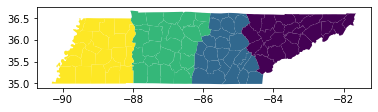

In [62]:
tenn_county_region.plot('tdot_region');

In [31]:
tenn_eq.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-10-19T20:19:38.490Z,36.224000,-82.817167,17.27,2.31,md,8.0,70.0,0.17510,0.12,...,2020-10-23T06:52:55.336Z,"6 km N of Greeneville, Tennessee",earthquake,0.91,1.69,0.099,6.0,reviewed,se,se
1,2020-10-17T07:12:44.060Z,35.366833,-85.213500,17.99,2.26,md,16.0,59.0,0.15870,0.14,...,2020-10-17T13:54:48.250Z,"4 km NNW of Flat Top Mountain, Tennessee",earthquake,0.33,0.60,0.152,15.0,reviewed,se,se
2,2020-10-09T20:24:02.590Z,36.101833,-83.637833,16.48,2.30,md,14.0,83.0,0.20410,0.11,...,2020-10-15T02:32:20.631Z,"7 km W of New Market, Tennessee",earthquake,0.29,0.94,0.090,10.0,reviewed,se,se
3,2020-09-13T11:45:06.680Z,35.706333,-83.916833,18.34,2.47,md,22.0,40.0,0.12590,0.16,...,2020-09-26T09:49:46.040Z,"7 km SE of Maryville, Tennessee",earthquake,0.24,0.52,0.080,18.0,reviewed,se,se
4,2020-09-12T01:50:54.200Z,36.266000,-83.463167,9.34,2.40,md,17.0,66.0,0.06175,0.23,...,2020-09-13T04:46:49.129Z,"4 km ESE of Rutledge, Tennessee",earthquake,0.76,1.16,0.071,14.0,reviewed,se,se


In [32]:
tenn_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             1075 non-null   object 
 1   latitude         1075 non-null   float64
 2   longitude        1075 non-null   float64
 3   depth            1070 non-null   float64
 4   mag              1075 non-null   float64
 5   magType          1075 non-null   object 
 6   nst              1031 non-null   float64
 7   gap              1031 non-null   float64
 8   dmin             972 non-null    float64
 9   rms              1031 non-null   float64
 10  net              1075 non-null   object 
 11  id               1075 non-null   object 
 12  updated          1075 non-null   object 
 13  place            1075 non-null   object 
 14  type             1075 non-null   object 
 15  horizontalError  1043 non-null   float64
 16  depthError       1042 non-null   float64
 17  magError      

In [33]:
def lat_long_to_point(row):
    return Point(row['longitude'], row['latitude'])

In [34]:
tenn_eq['position'] = tenn_eq.apply(lat_long_to_point, axis=1)

In [35]:
tenn_eq_geo = gpd.GeoDataFrame(tenn_eq, crs='epsg:4326', geometry=tenn_eq['position'])

In [36]:
tenn_eq_geo.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'position', 'geometry'],
      dtype='object')

In [38]:
tenn_eq_geo_map = gpd.sjoin(tenn_eq_geo, tenn_county_region, op='within')

In [39]:
tenn_eq_geo_map.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'position', 'geometry', 'index_right',
       'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA',
       'county_name', 'tdot_region', 'tdot_code'],
      dtype='object')

In [40]:
tenn_map = folium.Map(tiles='Stamen Terrain', location=[36.224,-82.8171667], zoom_start=6)

In [46]:
heatmapdata = [
    (row['geometry'].y, row['geometry'].x, row['mag']) for idx, row
        in tenn_eq_geo_map.iterrows()
            if row['geometry'] and not pd.isna(row['geometry'].x) and not pd.isna(row['geometry'].y and not pd.isna(row['mag']))
        ]

In [47]:
heatmapdata

[(36.224, -82.8171667, 2.31),
 (36.0703333, -82.7371667, 2.47),
 (36.2051667, -82.9211667, 2.0),
 (36.2155, -82.8473333, 2.16),
 (36.2056667, -82.8735, 2.38),
 (36.2061667, -82.8798333, 1.92),
 (36.207, -82.8606667, 1.8),
 (36.207, -82.8607, 1.8),
 (36.2148333, -82.8468333, 1.6),
 (36.2148, -82.8468, 1.6),
 (36.2048, -82.8623, 1.8),
 (36.2048333, -82.8623333, 1.8),
 (36.112, -82.82799999999997, 4.5),
 (35.3668333, -85.2135, 2.26),
 (35.1968333, -85.1328333, 1.2),
 (35.4333333, -85.1365, 1.82),
 (35.0271667, -85.2116667, 2.46),
 (35.2185, -85.0373333, 2.22),
 (35.1275, -85.1715, 2.42),
 (35.0548333, -85.0553333, 2.49),
 (35.0281667, -85.0218333, 2.02),
 (35.0601667, -85.0468333, 2.12),
 (35.3931667, -85.1953333, 2.3),
 (35.014, -85.1795, 2.58),
 (35.007, -85.05366670000002, 1.81),
 (34.9981667, -85.0708333, 2.38),
 (35.0195, -85.1932, 2.0),
 (35.020166700000004, -85.1956667, 2.0),
 (35.3641, -85.1955, 1.9),
 (35.3641667, -85.1955, 1.9),
 (35.078, -85.01, 2.2),
 (35.0779, -85.01, 2.2),
 

In [48]:
hm = HeatMap(data=heatmapdata)

In [49]:
hm.add_to(tenn_map);

In [50]:
tenn_map

In [51]:
tenn_eq_geo_map.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'position', 'geometry', 'index_right',
       'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA',
       'county_name', 'tdot_region', 'tdot_code'],
      dtype='object')

In [61]:
tenn_eq_geo_map.groupby(['tdot_region']).count()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,geometry,index_right,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,county_name,tdot_code
tdot_region,,,,,,,,,,,,,,,,,,,,,
1,706,706,706,705,706,706,689,689,654,689,...,706,706,706,706,706,706,706,706,706,706
2,309,309,309,309,309,309,305,305,289,305,...,309,309,309,309,309,309,309,309,309,309
3,21,21,21,21,21,21,15,15,13,15,...,21,21,21,21,21,21,21,21,21,21
4,16,16,16,14,16,16,6,6,3,6,...,16,16,16,16,16,16,16,16,16,16


# Earthquakes in dataset = 1075
# Most likely = East Tenn
# Least likely = Middle Tenn